In [1]:
# 加载必要的库
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# 加载数据集
train_set = h5py.File("./datasets/train_catvnoncat.h5","r")
test_set = h5py.File("./datasets/test_catvnoncat.h5","r")

for key in train_set.keys():  # 查看训练集结构
    print(key)   # train_set_x  train_set_y
train_set['train_set_x'].shape # (209, 64, 64, 3) 有209张图片，图片分辨率64*64，颜色通道为3
train_set['train_set_y'].shape # (209,) 标注图片标签（是否为猫）

for key in test_set.keys():  # 查看测试集结构
    print(key)    # test_set_x   test_set_y
test_set['test_set_x'].shape # (50, 64, 64, 3) 有50张图片，图片分辨率64*64，颜色通道为3 
test_set['test_set_y'].shape # (50,) 标注图片标签（是否为猫）

# 将数据集中的内容和标签分开
train_data_org = train_set['train_set_x'][:]  # 保存的是训练集里面的图像数据，即209张64x64的3通道图像
train_labels_org = train_set['train_set_y'][:] # 保存的是训练集的图像对应的分类值，其中0表示不是猫，1表示是猫
test_data_org = test_set['test_set_x'][:] # 保存的是测试集里面的图像数据，即50张64x64的3通道图像
test_labels_org = test_set['test_set_y'][:] # 保存的是测试集里面的图像对应的分类值，其中0表示不是猫，1表示是猫

list_classes
train_set_x
train_set_y
list_classes
test_set_x
test_set_y


In [3]:
# 处理数据集------维度处理
# 对于训练集样本：(209, 64, 64, 3) ----> (12288, 209) 
# 对于测试集样本：(50, 64, 64, 3) ----->(12288, 50)
m_train = train_data_org.shape[0] # 训练集个数
m_test = test_data_org.shape[0] # 测试集个数
train_data_trans = train_data_org.reshape(m_train,-1).T # 训练集维度处理
test_data_trans = test_data_org.reshape(m_test,-1).T # 测试集维度处理
print(train_data_org.shape,test_data_org.shape)
print(train_data_trans.shape,test_data_trans.shape)

import numpy as np
# 对于训练集标签：(209,) ----> (1, 209)
# 对于测试集标签：(50,) -----> (1, 50)
train_labels_trans = train_labels_org.reshape(1,m_train) # 训练集标签维度处理
test_labels_trans = test_labels_org.reshape(1,m_test) # 训练集标签维度处理
print(train_labels_org.shape,test_labels_org.shape)
print(train_labels_trans.shape,test_labels_trans.shape)

(209, 64, 64, 3) (50, 64, 64, 3)
(12288, 209) (12288, 50)
(209,) (50,)
(1, 209) (1, 50)


In [4]:
# 处理数据集------标准化数据
train_data_norm = train_data_trans / 255
test_data_norm = test_data_trans / 255
print(train_data_trans)
print(train_data_norm)

[[ 17 196  82 ... 143  22   8]
 [ 31 192  71 ... 155  24  28]
 [ 56 190  68 ... 165  23  53]
 ...
 [  0  82 138 ...  85   4   0]
 [  0  80 141 ... 107   5   0]
 [  0  81 142 ... 149   0   0]]
[[0.06666667 0.76862745 0.32156863 ... 0.56078431 0.08627451 0.03137255]
 [0.12156863 0.75294118 0.27843137 ... 0.60784314 0.09411765 0.10980392]
 [0.21960784 0.74509804 0.26666667 ... 0.64705882 0.09019608 0.20784314]
 ...
 [0.         0.32156863 0.54117647 ... 0.33333333 0.01568627 0.        ]
 [0.         0.31372549 0.55294118 ... 0.41960784 0.01960784 0.        ]
 [0.         0.31764706 0.55686275 ... 0.58431373 0.         0.        ]]


In [5]:
# 定义超参数
EPOCHS = 3000
ALPHA = 0.0075
layers_dims = [12288,7,1] # 神经网络

In [6]:
# 初始化参数
def init_params(layer):
    n_x = layers_dims[layer-1]
    n_h = layers_dims[layer]
    W = np.random.randn(n_h,n_x)/np.sqrt(layers_dims[layer - 1])
    b = np.zeros((n_h,1))
    return W,b

In [7]:
# 前向和反向传播 2层
def forward_backward(X, Y, W1, W2, b1, b2):
    # 前向传播
    Z1 = np.dot(W1,X)+b1
    assert(W1.shape == (7,12288))
    assert(b1.shape == (7,1))
    assert(Z1.shape == (7,209))
    A1 = np.maximum(0,Z1)
    assert(A1.shape == (7,209))
    Z2 = np.dot(W2,A1)+b2
    assert(W2.shape == (1,7))
    assert(b2.shape == (1,1))
    assert(Z2.shape == (1,209))
    A2 = 1/(1 + np.exp(-Z2))
    assert(A2.shape == (1,209))
    
    # 计算损失
    m = X.shape[1]
    J = -1/m * np.sum(Y * np.log(A2) + (1-Y) * np.log(1-A2))
    
    # 反向传播
    dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    
    dZ1 = np.array(dA1, copy=True) 
    dZ1[A1 <= 0] = 0
    
    dW1 = (1 / m) * np.dot(dZ1,X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    # 更新梯度
    W1 = W1 - ALPHA*dW1
    W2 = W2 - ALPHA*dW2
    b1 = b1 - ALPHA*db1
    b2 = b2 - ALPHA*db2 
    return W1, W2, b1, b2,J

In [8]:
# 预测
def predict(W1,b1,W2,b2,X):
    # 前向传播
    Z1 = np.dot(W1,X)+b1
    A1 = np.maximum(0,Z1)
    Z2 = np.dot(W2,A1)+b2
    A2 = 1/(1 + np.exp(-Z2))
    
    m = X.shape[1]
    y_pred = np.zeros((1,m))
    for i in range(m):
        if A2[:,i] > 0.5:
            y_pred[:,i] = 1
        else:
            y_pred[:,i] = 0

    return y_pred

In [9]:
# 模型整合 
def nn_model(X,Y,test_data_norm,test_labels_trans):
    W1,b1 = init_params(1)
    W2,b2 = init_params(2)
    costs = []
    for i in range (EPOCHS):
        W1, W2, b1, b2, J = forward_backward(X, Y, W1, W2, b1 ,b2)
        if i%100 == 0:
            costs.append(J)
            print("迭代次数为：",i,"损失是：",J)
    y_pred_train = predict(W1,b1,W2,b2,X)
    y_pred_test = predict(W1,b1,W2,b2,test_data_norm)
    print("训练集上的准确率：",np.mean(y_pred_train == Y)*100,'%')
    print("测试集上的准确率：",np.mean(y_pred_test == test_labels_trans)*100,'%')
    return costs,W1,W2,b1,b2

In [10]:
# 调用
costs,W1,W2,b1,b2 = nn_model(train_data_norm,train_labels_trans,test_data_norm,test_labels_trans)

迭代次数为： 0 损失是： 0.6674161620471026
迭代次数为： 100 损失是： 0.5088904046135416
迭代次数为： 200 损失是： 0.4244257459275634
迭代次数为： 300 损失是： 0.36932577726615984
迭代次数为： 400 损失是： 0.3152874621351781
迭代次数为： 500 损失是： 0.2610005439393773
迭代次数为： 600 损失是： 0.20739307563051282
迭代次数为： 700 损失是： 0.15356835592927312
迭代次数为： 800 损失是： 0.12506712414394897
迭代次数为： 900 损失是： 0.08911258386474787
迭代次数为： 1000 损失是： 0.07386978431377164
迭代次数为： 1100 损失是： 0.06203475480618112
迭代次数为： 1200 损失是： 0.05304330187796015
迭代次数为： 1300 损失是： 0.046008737607934655
迭代次数为： 1400 损失是： 0.04026139433123711
迭代次数为： 1500 损失是： 0.035635167532809195
迭代次数为： 1600 损失是： 0.031749890333046975
迭代次数为： 1700 损失是： 0.02852467871925387
迭代次数为： 1800 损失是： 0.02579294100821856
迭代次数为： 1900 损失是： 0.023468076927312106
迭代次数为： 2000 损失是： 0.021467701832006747
迭代次数为： 2100 损失是： 0.019734542030684664
迭代次数为： 2200 损失是： 0.018224244175711047
迭代次数为： 2300 损失是： 0.01690068442037788
迭代次数为： 2400 损失是： 0.015730654123692935
迭代次数为： 2500 损失是： 0.01468821645892994
迭代次数为： 2600 损失是： 0.013758544259377344
迭代次数为： 27

Text(0, 0.5, 'cost')

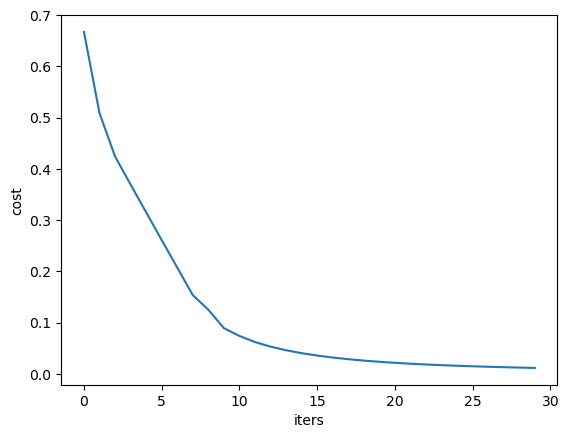

In [11]:
# 绘图
plt.plot(costs)
plt.xlabel("iters")
plt.ylabel("cost")